In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import regularizers

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


In [2]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfanmhn","key":"8c6ff62c1ed51f68fe4f46fb9c0b3d31"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nexuswho/tomatofruits
!unzip tomatofruits.zip

Dataset URL: https://www.kaggle.com/datasets/nexuswho/tomatofruits
License(s): other
 92% 143M/156M [00:00<00:00, 1.50GB/s]
100% 156M/156M [00:00<00:00, 1.47GB/s]
Archive:  tomatofruits.zip
  inflating: Three Classes/Reject/reject (1).jpg  
  inflating: Three Classes/Reject/reject (10).jpg  
  inflating: Three Classes/Reject/reject (100).jpg  
  inflating: Three Classes/Reject/reject (101).jpg  
  inflating: Three Classes/Reject/reject (102).jpg  
  inflating: Three Classes/Reject/reject (103).jpg  
  inflating: Three Classes/Reject/reject (104).jpg  
  inflating: Three Classes/Reject/reject (105).jpg  
  inflating: Three Classes/Reject/reject (106).jpg  
  inflating: Three Classes/Reject/reject (107).jpg  
  inflating: Three Classes/Reject/reject (108).jpg  
  inflating: Three Classes/Reject/reject (109).jpg  
  inflating: Three Classes/Reject/reject (11).jpg  
  inflating: Three Classes/Reject/reject (110).jpg  
  inflating: Three Classes/Reject/reject (111).jpg  
  inflating: Three 

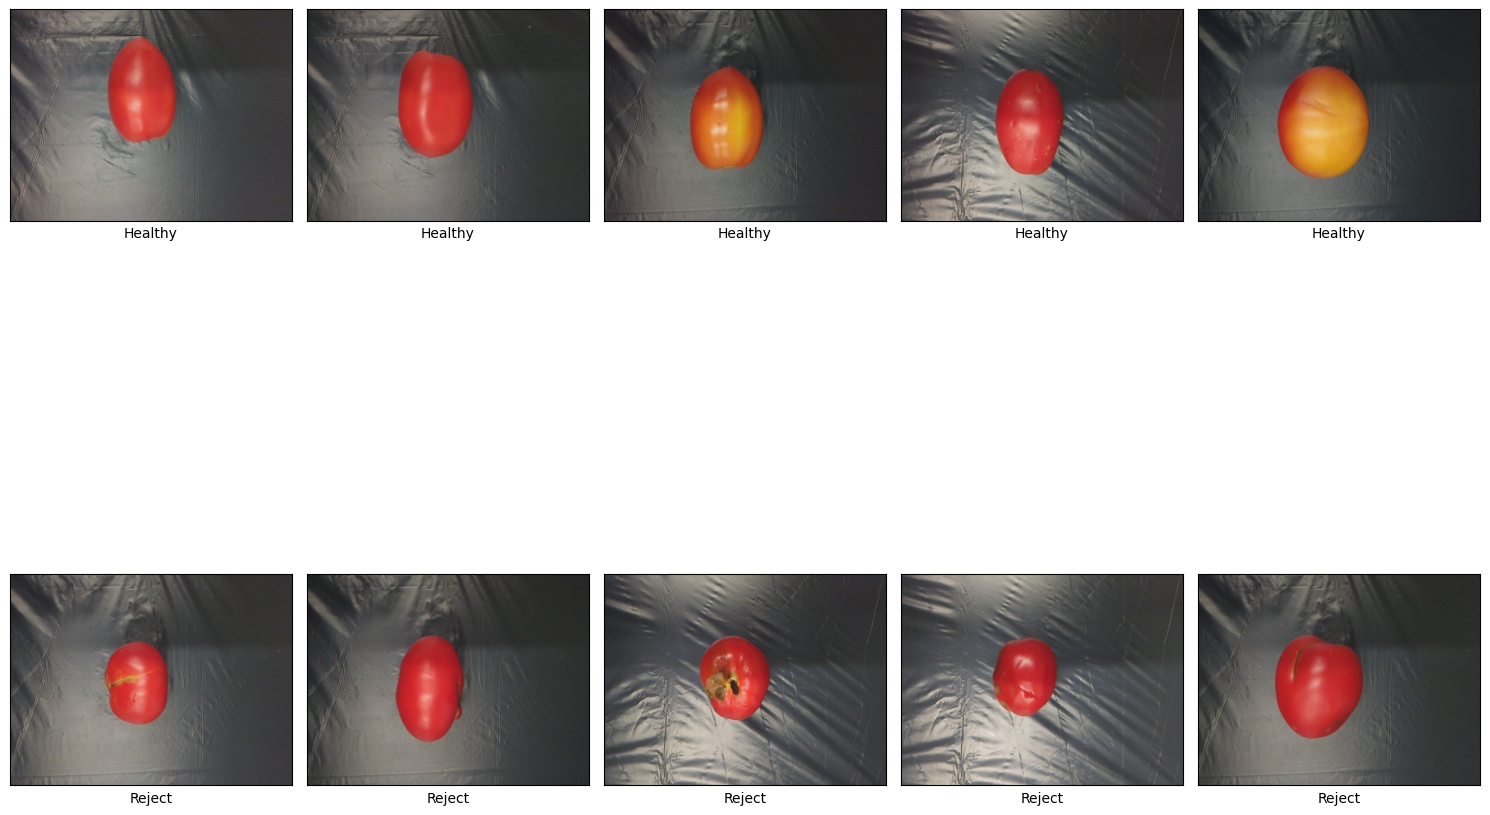

In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
tomato_image = {}

# Tentukan path sumber train
path = "/content/"
path_sub = os.path.join(path, "Two Classes")
for i in os.listdir(path_sub):
    tomato_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "/content/Two Classes"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(tomato_image.keys()), 5, figsize=(15, 15))


for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(tomato_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

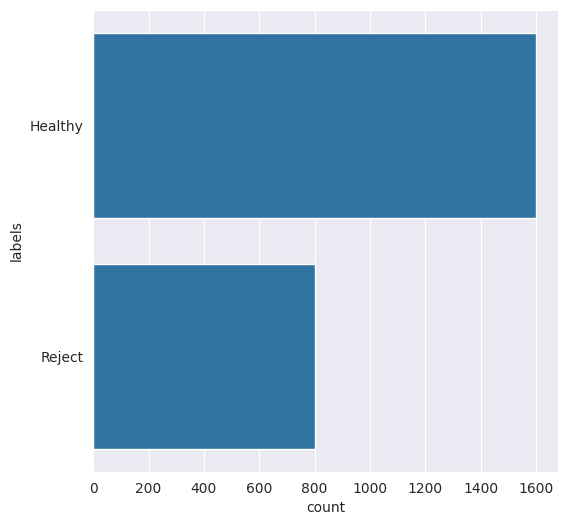

In [6]:
# Definisikan path sumber
tomato_path = "/content/Two Classes"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(tomato_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [7]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [8]:
images_path="/content/Two Classes/Reject" # Path untuk gambar asli
augmented_path="/content/Two Classes/Reject_augmented" # Path untuk gambar yang sudah diaugmentasi
os.makedirs(augmented_path, exist_ok=True)

# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }


images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=800
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [9]:
import shutil
import os

# Path folder
original_folder = "/content/Two Classes/Reject"
augmented_folder = "/content/Two Classes/Reject_augmented"

# Copy semua file dari folder augmented ke folder asli
for filename in os.listdir(augmented_folder):
    src_path = os.path.join(augmented_folder, filename)
    dst_path = os.path.join(original_folder, filename)

    # Pastikan nama file tidak duplikat
    counter = 1
    while os.path.exists(dst_path):
        name, ext = os.path.splitext(filename)
        dst_path = os.path.join(original_folder, f"{name}_{counter}{ext}")
        counter += 1

    shutil.copy(src_path, dst_path)

print(f"Berhasil menyalin {len(os.listdir(augmented_folder))} gambar ke folder asli")

Berhasil menyalin 800 gambar ke folder asli


In [10]:
# 3. Hapus folder augmentasi beserta isinya
shutil.rmtree(augmented_folder)
print(f"🗑️ Folder augmentasi {augmented_folder} telah dihapus")

# 4. Verifikasi hasil
print(f"\nJumlah file akhir di folder asli: {len(os.listdir(original_folder))}")

🗑️ Folder augmentasi /content/Two Classes/Reject_augmented telah dihapus

Jumlah file akhir di folder asli: 1600


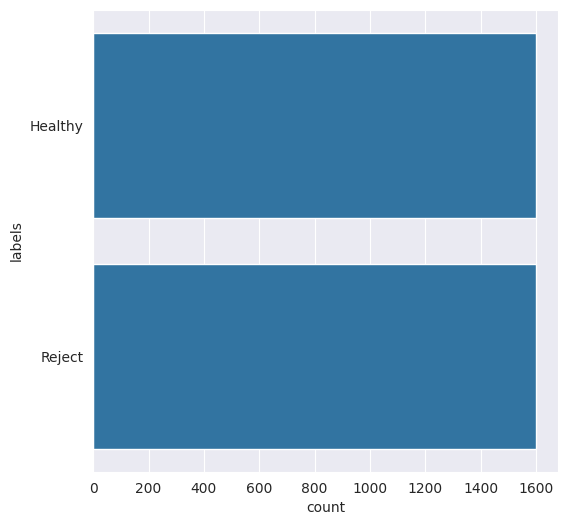

In [11]:
# Definisikan path sumber
tomato_path = "/content/Two Classes"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(tomato_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/Two Classes'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Healthy,1600
Reject,1600


In [13]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [14]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [15]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/Two_Classes"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels 
test   Healthy     331
       Reject      309
train  Healthy    1269
       Reject     1291
dtype: int64 


                                                path   labels    set
1109    /content/Two Classes/Reject/reject (713).jpg   Reject  train
2606   /content/Two Classes/Healthy/unripe (537).jpg  Healthy   test
884   /content/Two Classes/Healthy/healthy (807).jpg  Healthy  train
1997    /content/Two Classes/Reject/reject (302).jpg   Reject  train
2466  /content/Two Classes/Healthy/healthy (111).jpg  Healthy  train


In [16]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [17]:
# Definisikan direktori training dan test
TRAIN_DIR = "/content/Dataset-Final/train"
TEST_DIR = "/content/Dataset-Final/test"

train_healthy = os.path.join(TRAIN_DIR + '/Healthy')
train_reject = os.path.join(TRAIN_DIR + '/Reject')
test_healthy = os.path.join(TEST_DIR + '/Healthy')
test_reject = os.path.join(TEST_DIR + '/Reject')

print("Total number of healthy tomato images in training set: ",len(os.listdir(train_healthy)))
print("Total number of rejected tomato images in training set: ",len(os.listdir(train_reject)))
print("Total number of healthy tomato images in test set: ",len(os.listdir(test_healthy)))
print("Total number of rejected tomato images in test set: ",len(os.listdir(test_reject)))

Total number of healthy tomato images in training set:  1269
Total number of rejected tomato images in training set:  1291
Total number of healthy tomato images in test set:  331
Total number of rejected tomato images in test set:  309


In [18]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              color_mode="rgb",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                color_mode="rgb",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  color_mode="rgb",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 2049 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

# 1. Load the MobileNetV2 model pre-trained on ImageNet, excluding its top (classification) layer.
# Changed input_shape to (224, 224, 3) to match default supported sizes and avoid UserWarning.
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# 2. Freeze the layers of the loaded base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Create a new Sequential model for the classification head
# This head should consist of a GlobalAveragePooling2D layer, a Dense layer with 512 units and 'relu' activation,
# and a final Dense layer with 1 unit and 'sigmoid' activation for binary classification.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# 4. Combine the frozen MobileNetV2 base model and the new classification head to create model_transfer
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# Print the summary of the model_transfer to verify its architecture
print(model_transfer.summary())


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [21]:
# Implement EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=10,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',   # Monitor validation accuracy
    factor=0.2,               # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,               # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001,           # Lower bound on the learning rate.
    verbose=1                 # Print messages when the learning rate is updated.
)

# Combine callbacks into a list
callbacks = [early_stopping, reduce_lr]

In [22]:
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history_transfer = model_transfer.fit(train_generator,
                                      epochs=30,
                                      validation_data=validation_generator,
                                      callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 542ms/step - accuracy: 0.8207 - loss: 0.3692 - val_accuracy: 0.9393 - val_loss: 0.1643 - learning_rate: 0.0010
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8954 - loss: 0.2399 - val_accuracy: 0.8493 - val_loss: 0.4739 - learning_rate: 0.0010
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9397 - loss: 0.1611 - val_accuracy: 0.8454 - val_loss: 0.5306 - learning_rate: 0.0010
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9364 - loss: 0.1628 - val_accuracy: 0.8571 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9512 - loss: 0.1300 - val_accuracy: 0.8513 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9492 - loss: 0.1260
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9493 - loss: 0.1260 - va

640/640 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9715 - loss: 0.0911
Test Loss: 0.2816
Test Accuracy: 0.9000


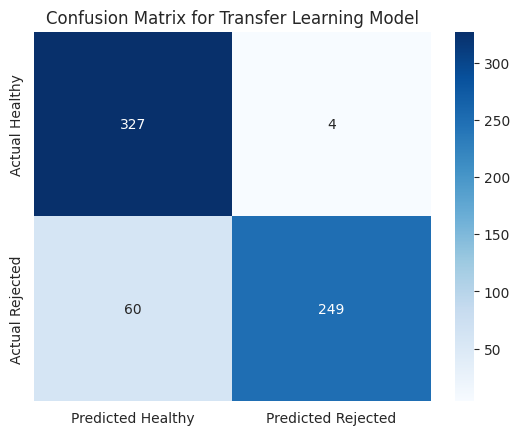


Classification Report for Transfer Learning Model:

              precision    recall  f1-score   support

     Healthy     0.8450    0.9879    0.9109       331
    Rejected     0.9842    0.8058    0.8861       309

    accuracy                         0.9000       640
   macro avg     0.9146    0.8969    0.8985       640
weighted avg     0.9122    0.9000    0.8989       640



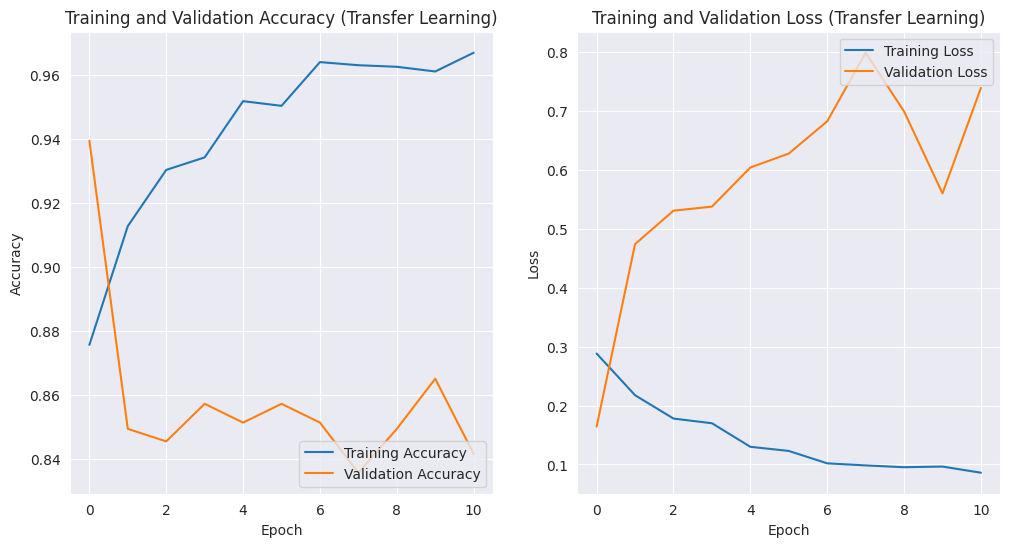

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Evaluate the trained model on the test_generator
loss_transfer, accuracy_transfer = model_transfer.evaluate(test_generator)
print(f"Test Loss: {loss_transfer:.4f}")
print(f"Test Accuracy: {accuracy_transfer:.4f}")

# Predict classes for the test set
test_generator.reset()
preds_transfer = model_transfer.predict(test_generator, verbose=0)
preds_transfer = np.where(preds_transfer <= 0.5, 0, 1)

# Calculate and display the confusion matrix as a heatmap
cm_transfer = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_transfer, labels=[0, 1]),
                           index=["Actual Healthy", "Actual Rejected"],
                           columns=["Predicted Healthy", "Predicted Rejected"])
sns.heatmap(cm_transfer, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Transfer Learning Model')
plt.show()

# Print the classification report
print("\nClassification Report for Transfer Learning Model:\n")
print(classification_report(y_true=test_generator.classes, y_pred=preds_transfer, target_names=['Healthy', 'Rejected'], digits=4))

# Plot training and validation accuracy and loss curves
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']
loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()